# 短程-三種價格建模

## 特徵重要性圖


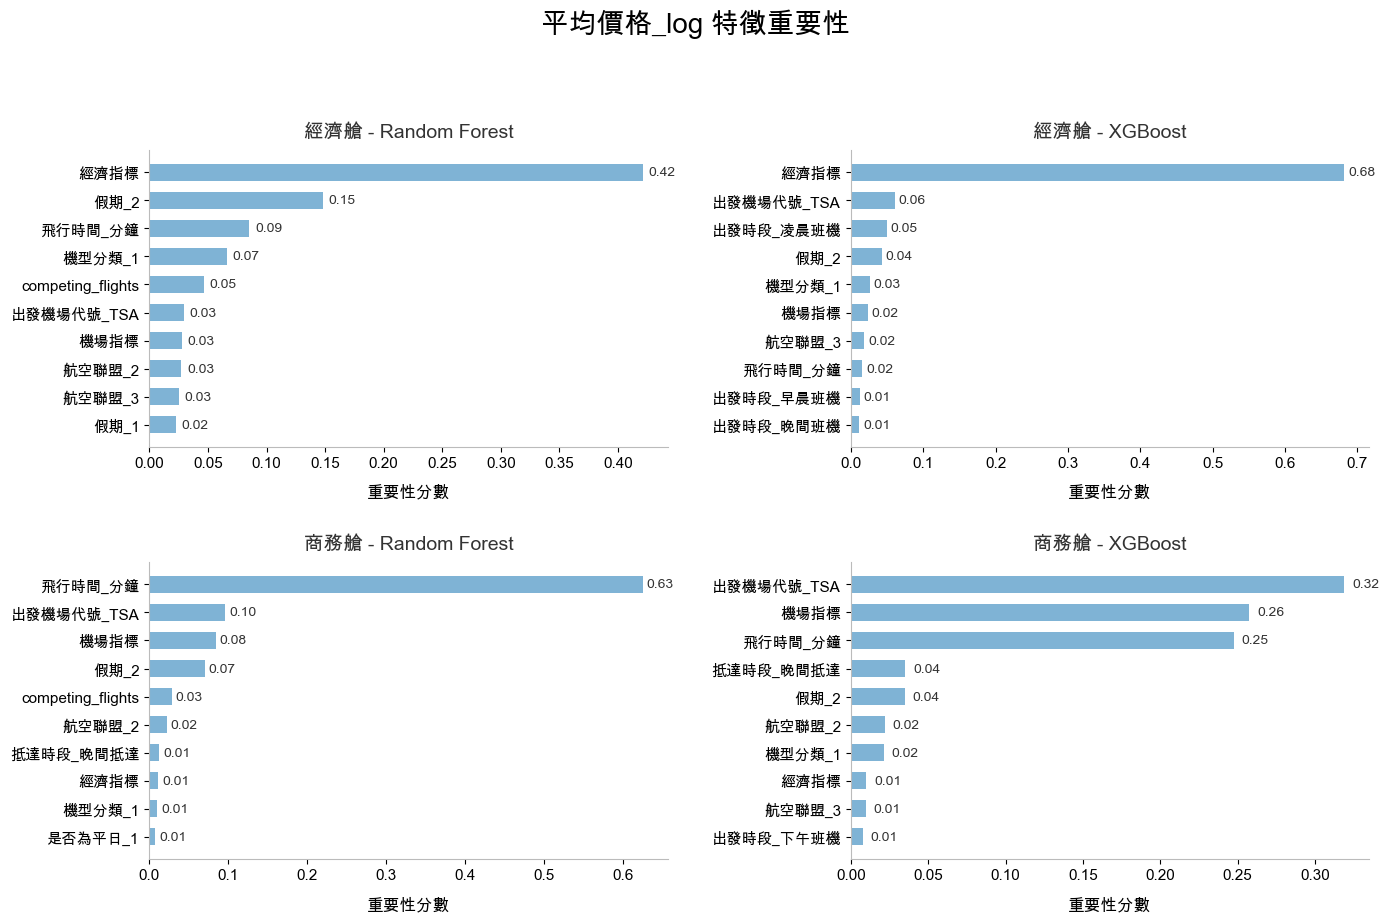

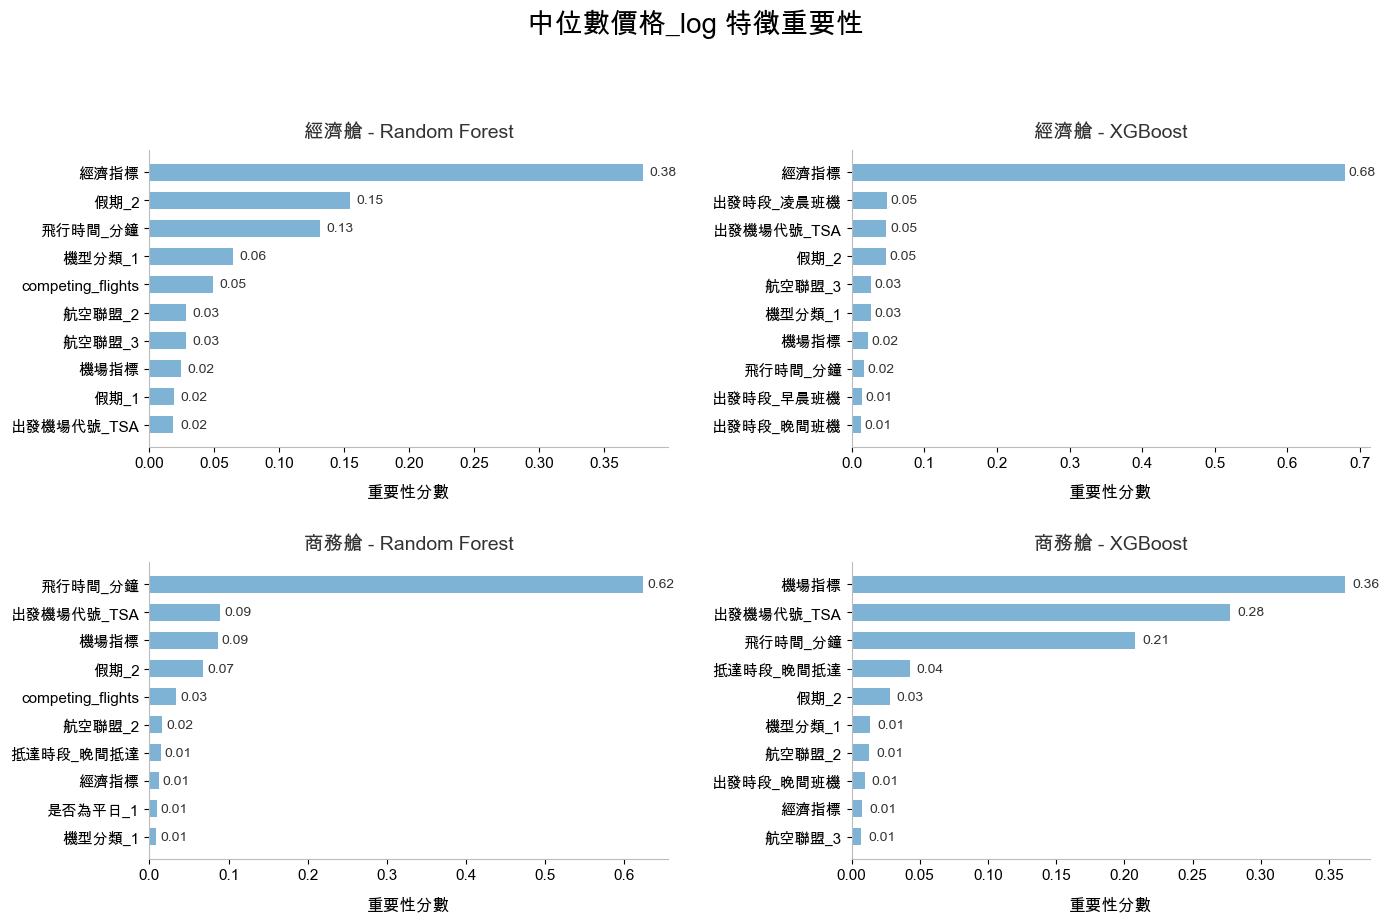

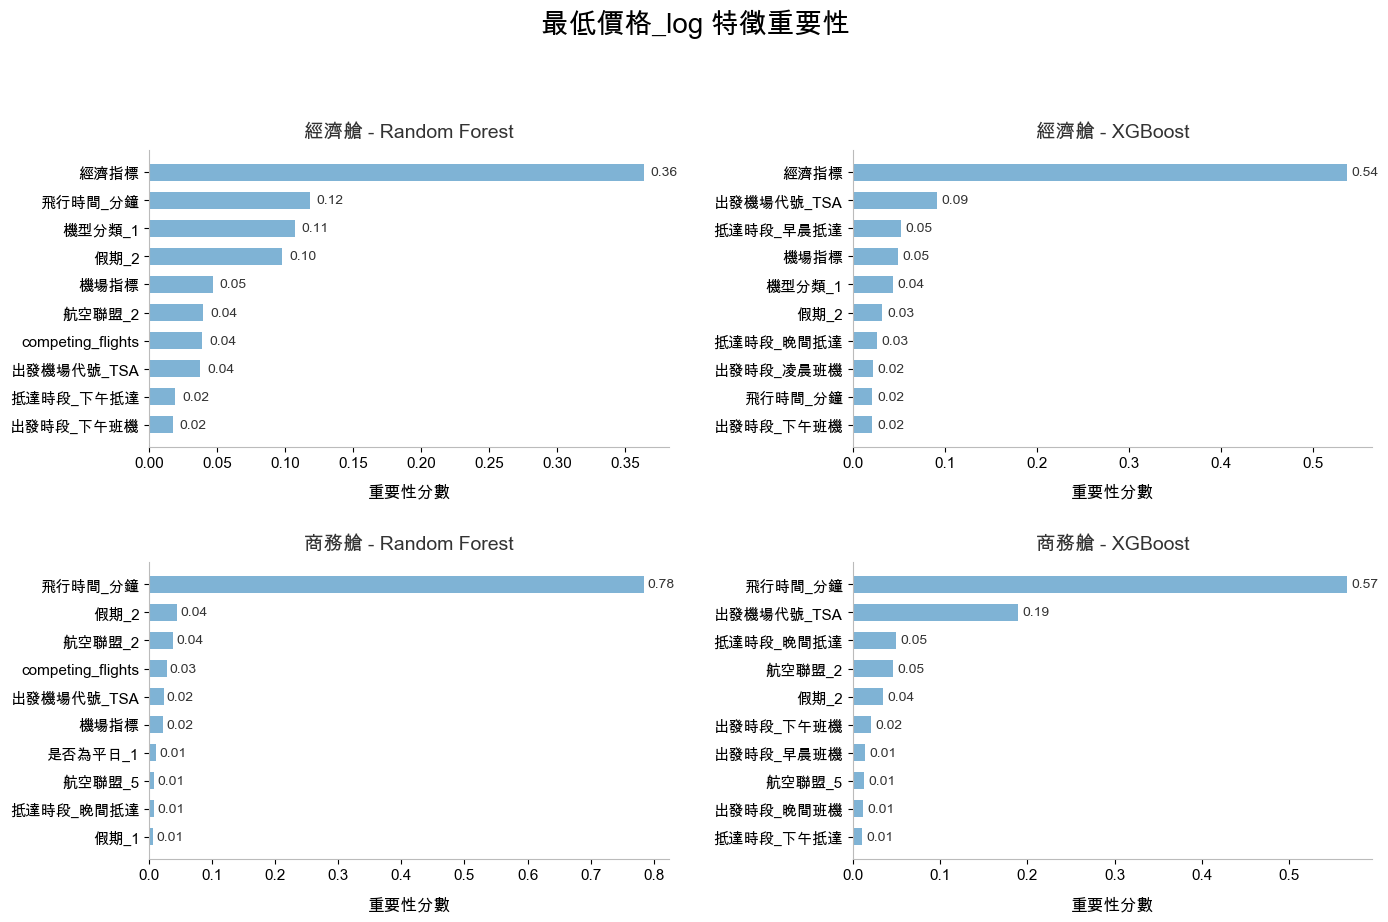

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import FuncFormatter

# 中文設定
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 載入資料
file_path = '/Users/yuchingchen/Documents/專題/merge_and_cleaned/final_data/short_flight.csv'
data = pd.read_csv(file_path)

# 分離艙等
eco_data = data[data["艙等"] == "經濟艙"].copy()
biz_data = data[data["艙等"] == "商務艙"].copy()

# One-hot encoding
categorical_cols = ['出發時段', '出發機場代號', '抵達時段', '抵達機場代號',
                    '航空公司', '航空聯盟', '機型分類', '是否過夜', '是否為平日', '機型', '假期']
eco_data = pd.get_dummies(eco_data, columns=categorical_cols, drop_first=True)
biz_data = pd.get_dummies(biz_data, columns=categorical_cols, drop_first=True)

# 保留共同欄位
common_cols = list(set(eco_data.columns) & set(biz_data.columns))
eco_data = eco_data[common_cols]
biz_data = biz_data[common_cols]

# 標準化
num_cols = ['飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']
scaler = StandardScaler()
eco_data[num_cols] = scaler.fit_transform(eco_data[num_cols])
biz_data[num_cols] = scaler.transform(biz_data[num_cols])

# 特徵欄位
target_keywords = ['出發時段_', '出發機場代號_', '抵達時段_', '航空聯盟_', '機型分類_', '假期_', '是否為平日_']
feature_cols = [col for col in eco_data.columns if any(k in col for k in target_keywords)] + num_cols
X_eco = eco_data[feature_cols]
X_biz = biz_data[feature_cols]

# 定義模型訓練 + 繪圖
def plot_importance(X, y_eco, y_biz, title):

    fig, axes = plt.subplots(2, 2, figsize=(14, 9))
    fig.suptitle(f"{title} 特徵重要性", fontsize=20, fontweight='bold', y=1.02)

    # 柔和藍色系
    bar_color = "#7FB3D5"
    text_color = "#333333"

    def draw_barh(ax, series, subtitle):
        top_features = series.sort_values(ascending=False).head(10)
        bars = ax.barh(top_features.index, top_features.values,
                       color=bar_color, edgecolor='none', height=0.6)
        ax.set_title(subtitle, fontsize=14, fontweight='semibold', color=text_color, pad=10)
        ax.set_xlabel("重要性分數", fontsize=12, labelpad=10)
        ax.tick_params(axis='both', labelsize=11)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('#BBBBBB')
        ax.spines['bottom'].set_color('#BBBBBB')
        ax.invert_yaxis()

        # 加上數值標籤（靠右邊框對齊）
        for bar in bars:
            width = bar.get_width()
            ax.text(width + 0.005, bar.get_y() + bar.get_height()/2,
                    f"{width:.2f}", va='center', fontsize=10, color=text_color)

    # 經濟艙
    rf = RandomForestRegressor(n_estimators=200, random_state=123, n_jobs=-1)
    rf.fit(X_eco, y_eco)
    rf_imp_eco = pd.Series(rf.feature_importances_, index=X_eco.columns)
    draw_barh(axes[0, 0], rf_imp_eco, "經濟艙 - Random Forest")

    xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6,
                       random_state=123, n_jobs=-1, verbosity=0)
    xgb.fit(X_eco, y_eco)
    xgb_imp_eco = pd.Series(xgb.feature_importances_, index=X_eco.columns)
    draw_barh(axes[0, 1], xgb_imp_eco, "經濟艙 - XGBoost")

    # 商務艙
    rf.fit(X_biz, y_biz)
    rf_imp_biz = pd.Series(rf.feature_importances_, index=X_biz.columns)
    draw_barh(axes[1, 0], rf_imp_biz, "商務艙 - Random Forest")

    xgb.fit(X_biz, y_biz)
    xgb_imp_biz = pd.Series(xgb.feature_importances_, index=X_biz.columns)
    draw_barh(axes[1, 1], xgb_imp_biz, "商務艙 - XGBoost")

    plt.tight_layout(h_pad=2.5, w_pad=2.5, rect=[0, 0, 1, 0.96])
    plt.show()

# 三種價格：平均、中位數、最低
plot_importance(X_eco, eco_data["平均價格_log"], biz_data["平均價格_log"], "平均價格_log")
plot_importance(X_eco, eco_data["中位數價格_log"], biz_data["中位數價格_log"], "中位數價格_log")
plot_importance(X_eco, eco_data["最低價格_log"], biz_data["最低價格_log"], "最低價格_log")

## 找最佳參數

In [ ]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed
from scipy.stats import uniform, randint

# --------------------------
# 讀取與前處理資料
# --------------------------
file_path = '/Users/yuching/Library/Mobile Documents/com~apple~CloudDocs/Documents/專題/merge_and_cleaned/final_data/short_flight.csv'
data = pd.read_csv(file_path)

# 分艙等
economy_class_data = data[data["艙等"] == "經濟艙"]
business_class_data = data[data["艙等"] == "商務艙"]

# One-hot encoding
categorical_cols = ['出發時段', '出發機場代號', '抵達時段', '航空聯盟', '機型分類', '是否為平日', '假期']
economy_class_data = pd.get_dummies(economy_class_data, columns=categorical_cols, drop_first=True)
business_class_data = pd.get_dummies(business_class_data, columns=categorical_cols, drop_first=True)

# 對齊欄位
common_cols = list(set(economy_class_data.columns) & set(business_class_data.columns))
economy_class_data = economy_class_data[common_cols]
business_class_data = business_class_data[common_cols]

# 標準化數值欄
num_cols = ['飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']
scaler = StandardScaler()
economy_class_data[num_cols] = scaler.fit_transform(economy_class_data[num_cols])
business_class_data[num_cols] = scaler.transform(business_class_data[num_cols])

# 特徵欄位
target_keywords = ['出發時段_', '出發機場代號_', '抵達時段_', '航空聯盟_', '機型分類_', '假期_', '是否為平日_']
economy_class_data_dummy_cols = [col for col in economy_class_data.columns if any(keyword in col for keyword in target_keywords)]
business_class_data_dummy_cols = [col for col in business_class_data.columns if any(keyword in col for keyword in target_keywords)]
economy_class_data_feature_cols = economy_class_data_dummy_cols + num_cols
business_class_data_feature_cols = business_class_data_dummy_cols + num_cols

# --------------------------
# 建模評估函式
# --------------------------
def run_model(seed, X, y, cabin_type):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    n_test = len(y_test)
    p = X.shape[1]
    result = {}

    # ------------------------
    # 🎯 Random Forest (GridSearchCV)
    # ------------------------
    rf_param_grid = {
        'n_estimators': [200, 250, 300],
        'max_depth': [20, 30],
        'min_samples_split': [4, 7, 9],
        'min_samples_leaf': [1, 2, 3, 4]
    }
    rf_model = GridSearchCV(
        RandomForestRegressor(random_state=seed),
        param_grid=rf_param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)
    print(f"[{cabin_type}] Best RF params (seed={seed}):", rf_model.best_params_)
    y_pred_rf = rf_model.predict(X_test)
    result['RandomForest'] = get_metrics(y_test, y_pred_rf, n_test, p)

    # ------------------------
    # 🎯 SVR (GridSearchCV)
    # ------------------------
    svr_param_grid = {
        'C': [5.0, 5.5, 6.0],
        'epsilon': [0.1, 0.15, 0.2],
        'gamma': ['scale']
    }
    svr_model = GridSearchCV(
        SVR(kernel='rbf'),
        param_grid=svr_param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=1  # SVR 訓練慢，n_jobs 設 1 較穩定
    )
    svr_model.fit(X_train, y_train)
    print(f"[{cabin_type}] Best SVR params (seed={seed}):", svr_model.best_params_)
    y_pred_svr = svr_model.predict(X_test)
    result['SVR'] = get_metrics(y_test, y_pred_svr, n_test, p)

    # ------------------------
    # 🎯 XGBoost (GridSearchCV)
    # ------------------------
    xgb_param_grid = {
        'n_estimators': [150, 200, 250],
        'learning_rate': [0.03, 0.05, 0.15],
        'max_depth': [5, 6],
        'subsample': [0.7, 0.8],
        'colsample_bytree': [0.7, 0.8]
    }
    xgb_model = GridSearchCV(
        XGBRegressor(random_state=seed, n_jobs=-1, verbosity=0, tree_method='hist'),
        param_grid=xgb_param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    xgb_model.fit(X_train, y_train)
    print(f"[{cabin_type}] Best XGB params (seed={seed}):", xgb_model.best_params_)
    y_pred_xgb = xgb_model.predict(X_test)
    result['XGBoost'] = get_metrics(y_test, y_pred_xgb, n_test, p)

    return cabin_type, result

# 指標計算
def get_metrics(y_true, y_pred, n, p):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mse)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    return {'MSE': mse, 'R2': r2, 'RMSE': rmse, 'Adjusted_R2': adj_r2}

# 結果統計
def process_results(all_results, cabin_type):
    results = {
        'RandomForest': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []},
        'SVR': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []},
        'XGBoost': {'MSE': [], 'R2': [], 'RMSE': [], 'Adjusted_R2': []}
    }

    for _, res in all_results:
        for model in results:
            for metric in results[model]:
                results[model][metric].append(res[model][metric])

    avg_results = {model: {metric: np.mean(values) for metric, values in metrics.items()} for model, metrics in results.items()}

    print(f"\n📊 {cabin_type} - Average Performance over {len(seeds)} runs:")
    for model, scores in avg_results.items():
        print(f"{model}:")
        for metric, value in scores.items():
            print(f"  {metric} = {value:.4f}")

# --------------------------
# 執行評估三個目標變數
# --------------------------
seeds = [123]

def evaluate_target_column(y_col):
    print(f"\n🎯 評估目標變數：{y_col}\n" + "-" * 50)
    # 經濟艙
    results_eco = Parallel(n_jobs=2)(delayed(run_model)(
        seed,
        economy_class_data[economy_class_data_feature_cols],
        economy_class_data[y_col],
        "經濟艙"
    ) for seed in seeds)

    # 商務艙
    results_biz = Parallel(n_jobs=2)(delayed(run_model)(
        seed,
        business_class_data[business_class_data_feature_cols],
        business_class_data[y_col],
        "商務艙"
    ) for seed in seeds)

    process_results(results_eco, "經濟艙")
    process_results(results_biz, "商務艙")

# 執行三個目標變數
for target in ['平均價格_log', '中位數價格_log', '最低價格_log']:
    evaluate_target_column(target)


🎯 評估目標變數：平均價格_log
--------------------------------------------------
[經濟艙] Best RF params (seed=123): {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 300}
[經濟艙] Best SVR params (seed=123): {'C': 5.5, 'epsilon': 0.1, 'gamma': 'scale'}
[經濟艙] Best XGB params (seed=123): {'colsample_bytree': 0.7, 'learning_rate': 0.15, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
[商務艙] Best RF params (seed=123): {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 300}
[商務艙] Best SVR params (seed=123): {'C': 5.0, 'epsilon': 0.1, 'gamma': 'scale'}
[商務艙] Best XGB params (seed=123): {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 250, 'subsample': 0.8}

📊 經濟艙 - Average Performance over 1 runs:
RandomForest:
  MSE = 0.0528
  R2 = 0.8523
  RMSE = 0.2298
  Adjusted_R2 = 0.8507
SVR:
  MSE = 0.0576
  R2 = 0.8389
  RMSE = 0.2399
  Adjusted_R2 = 0.8372
XGBoost:
  MSE = 0.0491
  R2 = 0.8625
  RMSE = 0.2217
  Adjus

## 30次平均

python(73315) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(73316) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


==== 平均價格_log 平均表現 ====
經濟艙:
  RandomForest: MSE=0.0522, R2=0.8541
  SVR: MSE=0.0568, R2=0.8410
  XGBoost: MSE=0.0483, R2=0.8649
商務艙:
  RandomForest: MSE=0.0094, R2=0.8909
  SVR: MSE=0.0111, R2=0.8718
  XGBoost: MSE=0.0093, R2=0.8927


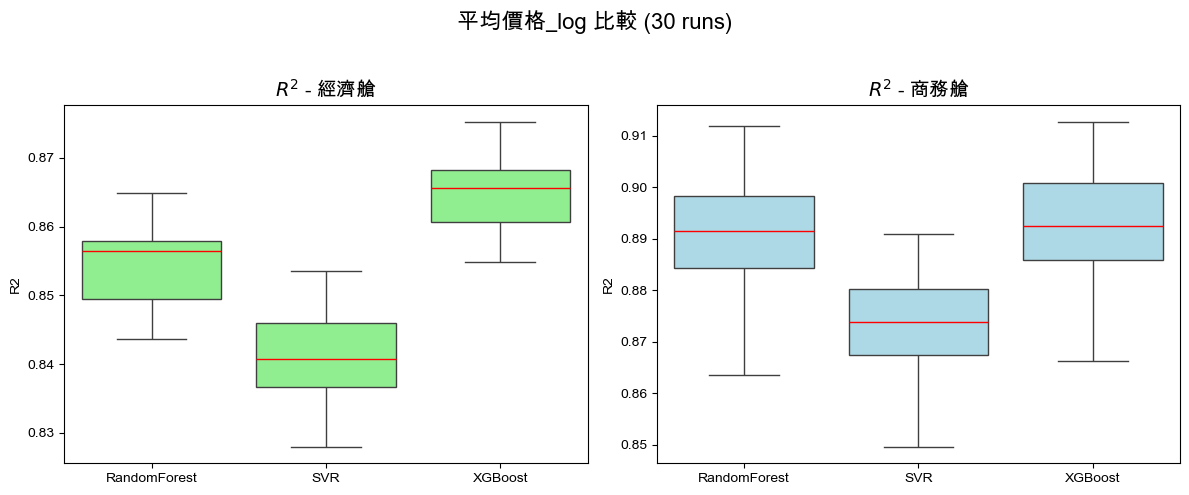

==== 中位數價格_log 平均表現 ====
經濟艙:
  RandomForest: MSE=0.0558, R2=0.8435
  SVR: MSE=0.0602, R2=0.8312
  XGBoost: MSE=0.0519, R2=0.8545
商務艙:
  RandomForest: MSE=0.0127, R2=0.8567
  SVR: MSE=0.0153, R2=0.8266
  XGBoost: MSE=0.0125, R2=0.8586


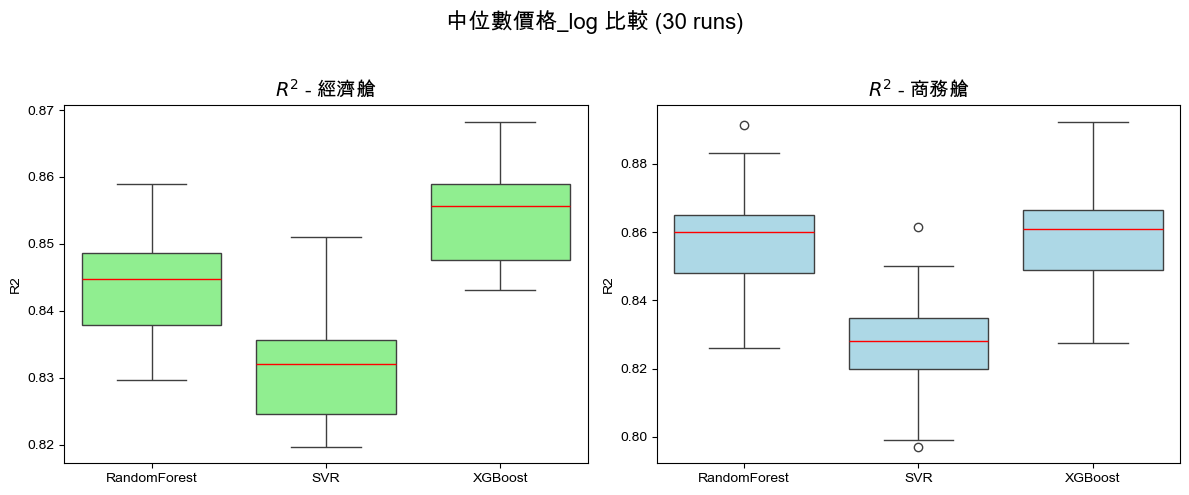

==== 最低價格_log 平均表現 ====
經濟艙:
  RandomForest: MSE=0.0417, R2=0.8643
  SVR: MSE=0.0476, R2=0.8450
  XGBoost: MSE=0.0403, R2=0.8690
商務艙:
  RandomForest: MSE=0.0119, R2=0.8480
  SVR: MSE=0.0143, R2=0.8181
  XGBoost: MSE=0.0119, R2=0.8488


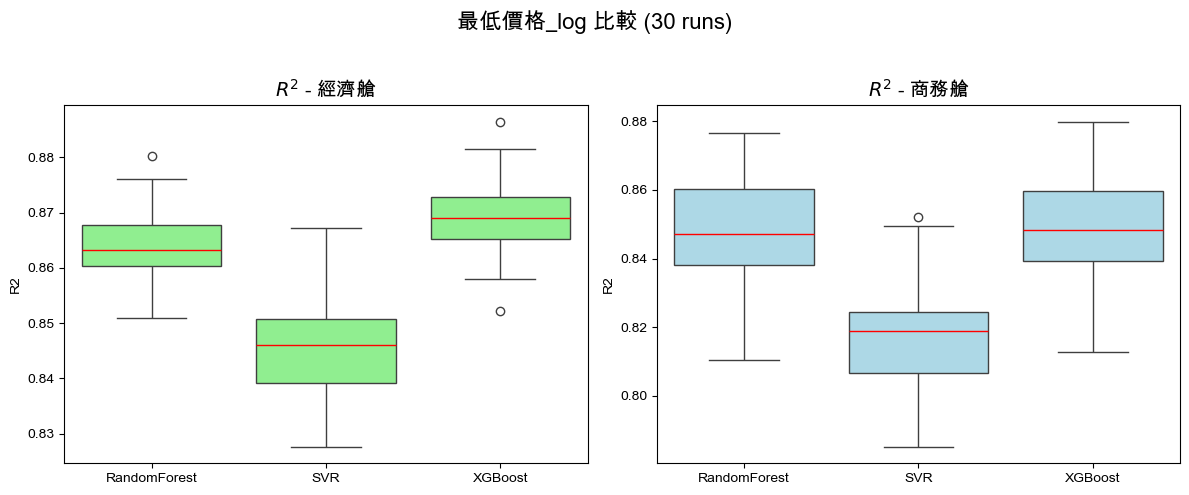

In [14]:
import os
os.environ["MallocStackLogging"] = "NO"
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed

# --------------------------
# 設定與前處理
# --------------------------
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

file_path = '/Users/yuchingchen/Documents/專題/merge_and_cleaned/final_data/short_flight.csv'
n_runs     = 30
seeds      = list(range(n_runs))
target_keywords = ['出發時段_', '出發機場代號_', '抵達時段_', '航空聯盟_', '機型分類_', '假期_', '是否為平日_']
num_cols  = ['飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']
categorical_cols = ['出發時段', '出發機場代號', '抵達時段', '航空聯盟', '機型分類', '是否為平日', '假期']

# 讀檔並 split
data      = pd.read_csv(file_path)
econ_data = data[data["艙等"]=="經濟艙"].copy()
biz_data  = data[data["艙等"]=="商務艙"].copy()

# One-hot & 同欄位 & 標準化
econ_data = pd.get_dummies(econ_data, columns=categorical_cols, drop_first=True)
biz_data  = pd.get_dummies(biz_data,  columns=categorical_cols, drop_first=True)
common    = list(set(econ_data.columns)&set(biz_data.columns))
econ_data = econ_data[common]
biz_data  = biz_data[common]

scaler    = StandardScaler()
econ_data[num_cols] = scaler.fit_transform(econ_data[num_cols])
biz_data [num_cols] = scaler.transform(   biz_data [num_cols])

# 建 feature list
def get_features(df):
    dummies = [c for c in df.columns if any(k in c for k in target_keywords)]
    return dummies + num_cols

econ_feats = get_features(econ_data)
biz_feats  = get_features(biz_data)

# --------------------------
# 最佳參數表（從 GridSearch 結果整理）
# --------------------------
best_params = {
    '平均價格_log': {
        '經濟艙': {
            'RandomForest': {'n_estimators': 300, 'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 1},
            'SVR': {'C': 6.0, 'epsilon': 0.15, 'gamma': 'scale'},
            'XGBoost': {'n_estimators': 250, 'learning_rate': 0.15, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7}
        },
        '商務艙': {
            'RandomForest': {'n_estimators': 250, 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 3},
            'SVR': {'C': 5.0, 'epsilon': 0.1, 'gamma': 'scale'},
            'XGBoost': {'n_estimators': 250, 'learning_rate': 0.05, 'max_depth': 5, 'subsample': 0.8, 'colsample_bytree': 0.7}
        }
    },
    '中位數價格_log': {
        '經濟艙': {
            'RandomForest': {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 1},
            'SVR': {'C': 6.0, 'epsilon': 0.1, 'gamma': 'scale'},
            'XGBoost': {'n_estimators': 150, 'learning_rate': 0.15, 'max_depth': 5, 'subsample': 0.8, 'colsample_bytree': 0.7}
        },
        '商務艙': {
            'RandomForest': {'n_estimators': 250, 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 4},
            'SVR': {'C': 5.0, 'epsilon': 0.1, 'gamma': 'scale'},
            'XGBoost': {'n_estimators': 250, 'learning_rate': 0.03, 'max_depth': 5, 'subsample': 0.8, 'colsample_bytree': 0.8}
        }
    },
    '最低價格_log': {
        '經濟艙': {
            'RandomForest': {'n_estimators': 200, 'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 2},
            'SVR': {'C': 6.0, 'epsilon': 0.1, 'gamma': 'scale'},
            'XGBoost': {'n_estimators': 150, 'learning_rate': 0.15, 'max_depth': 5, 'subsample': 0.8, 'colsample_bytree': 0.7}
        },
        '商務艙': {
            'RandomForest': {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 4},
            'SVR': {'C': 5.0, 'epsilon': 0.1, 'gamma': 'scale'},
            'XGBoost': {'n_estimators': 200, 'learning_rate': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7}
        }
    }
}

# --------------------------
# 執行模型
# --------------------------
def run_model(seed, X, y, model_params):
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=seed)
    n_test, p = len(yte), X.shape[1]
    out = {}
    models = {
        'RandomForest': RandomForestRegressor(random_state=seed, n_jobs=1, **model_params['RandomForest']),
        'SVR': SVR(**model_params['SVR']),
        'XGBoost': XGBRegressor(random_state=seed, n_jobs=1, tree_method='hist', **model_params['XGBoost'])
    }
    for name, mdl in models.items():
        mdl.fit(Xtr, ytr)
        pred = mdl.predict(Xte)
        mse  = mean_squared_error(yte, pred)
        r2   = r2_score(yte, pred)
        adj  = 1 - (1-r2)*(n_test-1)/(n_test-p-1)
        out[name] = {'MSE': mse, 'R2': r2, 'Adjusted_R2': adj}
    return out

# --------------------------
# 整理結果與畫圖
# --------------------------
def process_results(results_list):
    agg = {name: {'MSE':[], 'R2':[]} for name in results_list[0].keys()}
    for res in results_list:
        for m in agg:
            agg[m]['MSE'].append(res[m]['MSE'])
            agg[m]['R2'].append(res[m]['R2'])
    summary = {m: {'Average MSE': np.mean(v['MSE']), 'Average R2': np.mean(v['R2'])} for m,v in agg.items()}
    return summary, agg

def plot_r2_boxplots(econ_r2, biz_r2, title):
    fig, axes = plt.subplots(1,2, figsize=(12,5))
    def single_box(ax, r2_dict, cabin, color):
        clean_dict = {k: np.ravel(v).tolist() for k, v in r2_dict.items()}
        df = pd.DataFrame(clean_dict)
        df_long = df.melt(var_name='Model', value_name='R2')
        sns.boxplot(x='Model', y='R2', data=df_long, ax=ax,
                    boxprops={'facecolor':color}, medianprops={'color':'red'})
        ax.set_title(f"$R^2$ - {cabin}", fontsize=14)
        ax.set_xlabel('')
    single_box(axes[0], econ_r2, '經濟艙', 'lightgreen')
    single_box(axes[1], biz_r2,  '商務艙', 'lightblue')
    fig.suptitle(f"{title} 比較 ({n_runs} runs)", fontsize=16)
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

# --------------------------
# 執行主程式
# --------------------------
for target in ['平均價格_log', '中位數價格_log', '最低價格_log']:
    econ_param = best_params[target]['經濟艙']
    biz_param  = best_params[target]['商務艙']

    econ_out = Parallel(n_jobs=2)(
        delayed(run_model)(s, econ_data[econ_feats], econ_data[target], econ_param)
        for s in seeds
    )
    biz_out  = Parallel(n_jobs=2)(
        delayed(run_model)(s, biz_data[biz_feats], biz_data[target], biz_param)
        for s in seeds
    )

    # 整理結果與 R2 列表
    econ_summary, econ_agg = process_results(econ_out)
    biz_summary,  biz_agg  = process_results(biz_out)

    # 準備 R2 繪圖資料：僅取 R2 值
    econ_r2 = {model: vals['R2'] for model, vals in econ_agg.items()}
    biz_r2  = {model: vals['R2'] for model, vals in biz_agg.items()}

    # 列印平均 MSE & R2
    print(f"==== {target} 平均表現 ====")
    for cabin, summ in [('經濟艙', econ_summary), ('商務艙', biz_summary)]:
        print(f"{cabin}:")
        for model, scores in summ.items():
            print(f"  {model}: MSE={scores['Average MSE']:.4f}, R2={scores['Average R2']:.4f}")

    # 畫 boxplot
    plot_r2_boxplots(econ_r2, biz_r2, target)